In [1]:
!pip install -q -U imgaug

In [2]:
!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [3]:
!tar xf images.tar
!unzip -qq ./stanfordextra_v12.zip

unzip:  cannot find or open ./stanfordextra_v12.zip, ./stanfordextra_v12.zip.zip or ./stanfordextra_v12.zip.ZIP.


In [4]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [5]:
# 定义超参数
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2

In [7]:
# 加载数据
IMG_DIR = 'Images'
JSON = 'drive/MyDrive/面试项目/通过迁移学习进行关键点检测/StanfordExtra_V12/StanfordExtra_v12.json'
KEYPOINT_DEF = (
   "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

with open(JSON) as infile:
  json_data = json.load(infile)

json_dict = {i['img_path']: i for i in json_data}

In [13]:
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

colours = keypoint_def['Hex colour'].values.tolist()
colours = ['#' + colour for colour in colours]
labels = keypoint_def['Name'].values.tolist()

def get_dog(name):
  data = json_dict[name]
  img_data = plt.imread(os.path.join(IMG_DIR, data['img_path']))

  if img_data.shape[-1] == 4:
    img_data = img_data.astype(np.uint8)
    img_data = Image.fromarray(img_data)
    img_data = np.array(img_data.convert('RGB'))
  data['img_data'] = img_data

  return data

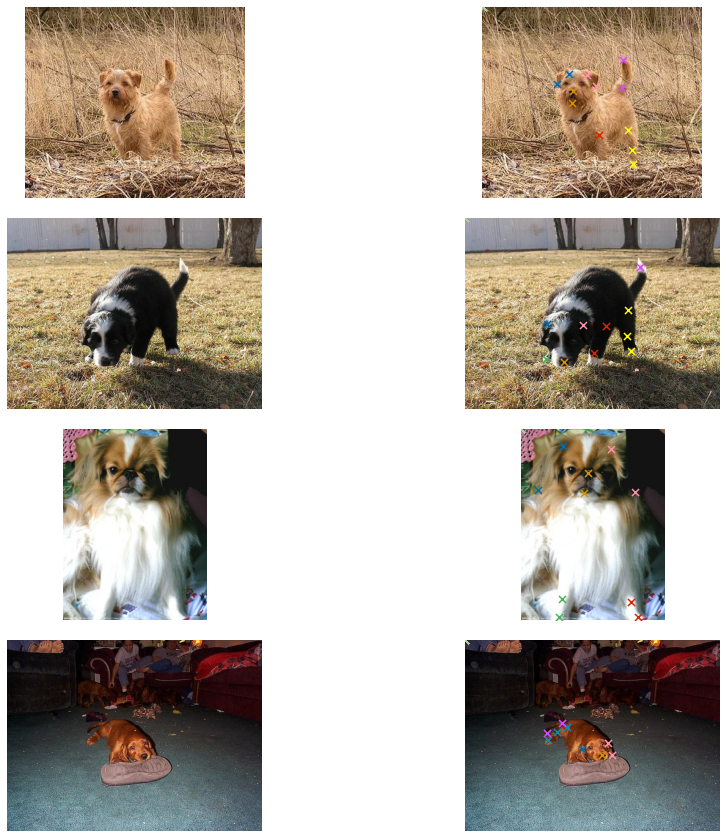

In [15]:
def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
  [ax.axis('off') for ax in np.ravel(axes)]

  for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
    ax_orig.imshow(image)
    ax_all.imshow(image)

    if isinstance(current_keypoint, KeypointsOnImage):
      for idx, kp in enumerate(current_keypoint.keypoints):
        ax_all.scatter(
            [kp.x], [kp.y], c=colours[idx], marker='x', s=50, linewidths=5
        )
    else:
      current_keypoint = np.array(current_keypoint)
      current_keypoint = current_keypoint[:, :2]
      for idx, (x,y) in enumerate(current_keypoint):
        ax_all.scatter([x], [y], c=colours[idx], marker='x', s=50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()

samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [],[]

for sample in selected_samples:
  data = get_dog(sample)
  image = data['img_data']
  keypoint = data['joints']

  images.append(image)
  keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [23]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [24]:
train_aug = iaa.Sequential(
    [
     iaa.Resize(IMG_SIZE, interpolation='linear'),
     iaa.Fliplr(0.3),
     iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7)))
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation='linear')])

In [25]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15):],
    samples[: int(len(samples) * 0.15)]
)

Total batches in training set: 166
Total batches in validation set: 29


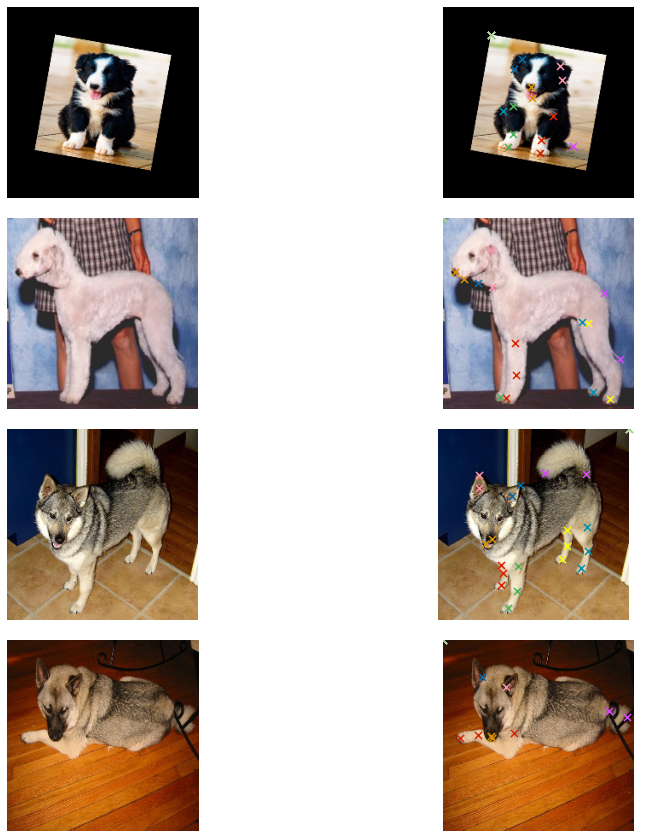

In [26]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [27]:
def get_model():
  backbone = keras.applications.MobileNetV2(
      weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
  )
  backbone.trainable = False

  inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
  x = keras.applications.mobilenet_v2.preprocess_input(inputs)
  x = backbone(x)
  x = layers.Dropout(0.3)(x)
  x = layers.SeparableConv2D(
      NUM_KEYPOINTS, kernel_size=5, strides=1, activation='relu'
  )(x)
  outputs = layers.SeparableConv2D(
      NUM_KEYPOINTS, kernel_size=3, strides=1, activation='sigmoid'
  )(x)

  return keras.Model(inputs, outputs, name='keypoint_detecotr')

In [28]:
get_model().summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "keypoint_detecotr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 3, 3, 48)          93488     
____________________________________________________

In [29]:
model = get_model()
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/5
166/166 [==============================] - 133s 602ms/step - loss: 0.1031 - val_loss: 0.0949
Epoch 2/5
166/166 [==============================] - 93s 558ms/step - loss: 0.0805 - val_loss: 0.0789
Epoch 3/5
166/166 [==============================] - 89s 534ms/step - loss: 0.0765 - val_loss: 0.0743
Epoch 4/5
166/166 [==============================] - 88s 531ms/step - loss: 0.0757 - val_loss: 0.0725
Epoch 5/5
166/166 [==============================] - 89s 534ms/step - loss: 0.0737 - val_loss: 0.0707


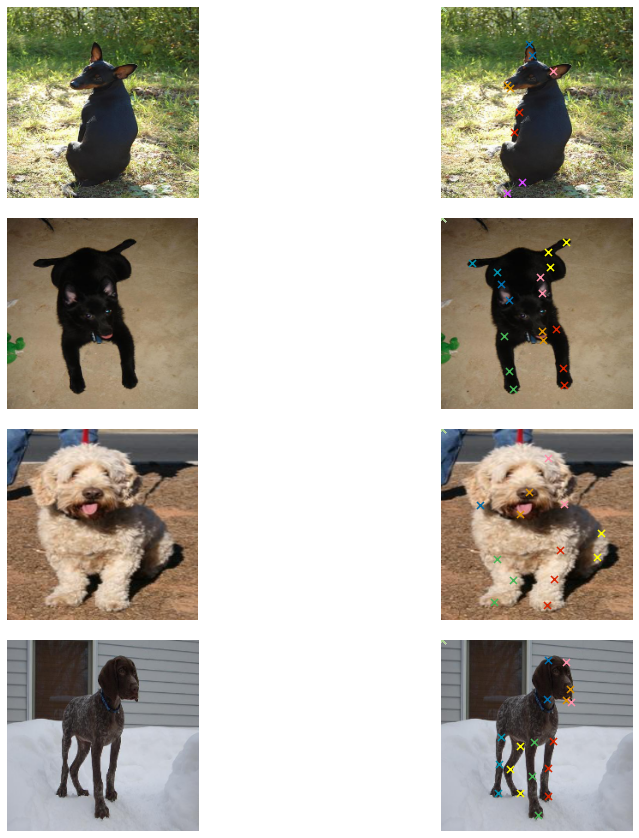

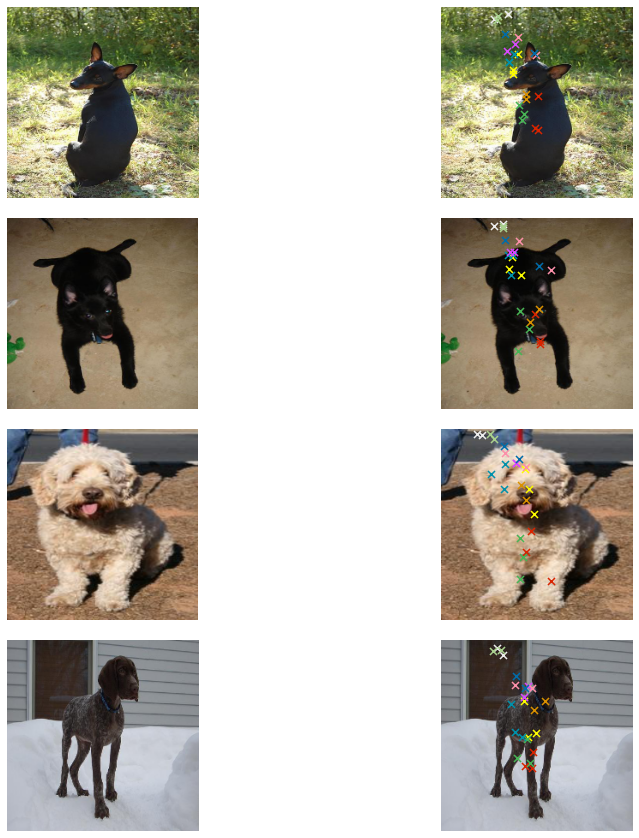

In [30]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMG_SIZE

visualize_keypoints(sample_val_images, sample_val_keypoints)

visualize_keypoints(sample_val_images, predictions)